# exponential smoothing(test)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
data_file =  '/content/drive/MyDrive/Flu Forecasting/code/trainingdata_rate0110.csv'

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/test result/'

df = pd.read_csv(data_file)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df['Week_end'] = pd.to_datetime(df['Week_end'])
start_date1 = pd.to_datetime('2023-11-01')
df_test = df[(df['Week_end'] > start_date1) & (df['Week_end'] < pd.to_datetime('2023-11-11'))]
df_train = df[(df['Week_end'] <= pd.to_datetime('2023-11-01'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]


df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = df_test['Week_end'].unique()
test_states = df_test['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=26)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




Streaming output truncated to the last 5000 lines.
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-1-c057e6457ef3>:51: FutureWarning: The frame.append method is deprecated and will 

In [ ]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)

<ipython-input-2-c26f378c4a2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0


In [ ]:
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/test result/expresult.csv',index = False)
quantile_result1


<ipython-input-3-102724fda8db>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


,location,reference_date,horizon,output_type_id,value,target,target_end_date,output_type
0,01,2023-11-11,0,0.010,22,wk inc flu hosp,2023-11-11,quantile
1,01,2023-11-11,0,0.025,26,wk inc flu hosp,2023-11-11,quantile
2,01,2023-11-11,0,0.050,29,wk inc flu hosp,2023-11-11,quantile
3,01,2023-11-11,0,0.100,33,wk inc flu hosp,2023-11-11,quantile
4,01,2023-11-11,0,0.150,36,wk inc flu hosp,2023-11-11,quantile
...,...,...,...,...,...,...,...,...
4595,56,2023-11-11,3,0.850,17,wk inc flu hosp,2023-12-02,quantile
4596,56,2023-11-11,3,0.900,20,wk inc flu hosp,2023-12-02,quantile
4597,56,2023-11-11,3,0.950,24,wk inc flu hosp,2023-12-02,quantile
4598,56,2023-11-11,3,0.975,28,wk inc flu hosp,2023-12-02,quantile


#### mae

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
desired_dates = ['2023-11-11', '2023-11-18', '2023-11-25', '2023-12-02']
hist = hist[hist['Week_end'].isin(desired_dates)]
hist = hist[['fips','Week_end','total_admissions']]
hist

,fips,Week_end,total_admissions
148,01,2023-11-11,60.0
149,01,2023-11-18,77.0
150,01,2023-11-25,73.0
151,01,2023-12-02,85.0
305,02,2023-11-11,39.0
...,...,...,...
7687,55,2023-12-02,59.0
7841,56,2023-11-11,5.0
7842,56,2023-11-18,9.0
7843,56,2023-11-25,23.0


In [ ]:
regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
regionresult = regionresult[regionresult['reference_date']=='2023-11-11']
merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

# Calculate the absolute difference between actual and predicted total admissions
merged_df['absolute_difference'] = abs(merged_df['total_admissions'] - merged_df['value'])

# Calculate the Mean Absolute Error (MAE)
mae = merged_df['absolute_difference'].mean()

# Print the MAE
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 30.935


In [ ]:
merged_df

,fips,Week_end,total_admissions,location,reference_date,horizon,output_type_id,value,target,target_end_date,output_type,absolute_difference
0,01,2023-11-11,60.0,01,2023-11-11,0,0.5,49,wk inc flu hosp,2023-11-11,quantile,11.0
1,01,2023-11-18,77.0,01,2023-11-11,1,0.5,73,wk inc flu hosp,2023-11-18,quantile,4.0
2,01,2023-11-25,73.0,01,2023-11-11,2,0.5,65,wk inc flu hosp,2023-11-25,quantile,8.0
3,01,2023-12-02,85.0,01,2023-11-11,3,0.5,52,wk inc flu hosp,2023-12-02,quantile,33.0
4,02,2023-11-11,39.0,02,2023-11-11,0,0.5,59,wk inc flu hosp,2023-11-11,quantile,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,55,2023-12-02,59.0,55,2023-11-11,3,0.5,46,wk inc flu hosp,2023-12-02,quantile,13.0
196,56,2023-11-11,5.0,56,2023-11-11,0,0.5,2,wk inc flu hosp,2023-11-11,quantile,3.0
197,56,2023-11-18,9.0,56,2023-11-11,1,0.5,3,wk inc flu hosp,2023-11-18,quantile,6.0
198,56,2023-11-25,23.0,56,2023-11-11,2,0.5,4,wk inc flu hosp,2023-11-25,quantile,19.0


## plot

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2023-11-11']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-10-01') & (hist['Week_end'] <= '2023-12-02')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01') & (quantile_data['target_end_date'] <= '2023-12-02')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# exponential smoothing(Prediction)


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])
data_file =  '/content/drive/MyDrive/Flu Forecasting/code/trainingdata_rate0117.csv'

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/weightselection/'

df = pd.read_csv(data_file)
df['fips'] = df['fips'].astype(str).str.zfill(2)
df['Week_end'] = pd.to_datetime(df['Week_end'])

'''
test for weights: reference date - 01/27,  we should use the (12/30) but use 12-23 as testing
'''

start_date1 = pd.to_datetime('2024-01-13')
#df_test = df[(df['Week_end'] >= start_date1) & (df['Week_end'] < pd.to_datetime('2024-01-21'))]
#df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-12'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]
df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-12'))]

df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = ['2024-01-13']
test_states = df_train['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=52)
    #model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal=None)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




Streaming output truncated to the last 5000 lines.
<ipython-input-15-be381eaaa2d8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-15-be381eaaa2d8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-15-be381eaaa2d8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-15-be381eaaa2d8>:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-15-be381eaaa2d8>:57: FutureWarning: The frame.append method is deprecated and 

In [2]:
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,01,2024-01-13,0,0.010,8.238745
1,01,2024-01-13,0,0.025,8.650744
2,01,2024-01-13,0,0.050,9.019752
3,01,2024-01-13,0,0.100,9.462739
4,01,2024-01-13,0,0.150,9.772633
...,...,...,...,...,...
4595,56,2024-01-13,3,0.850,84.217094
4596,56,2024-01-13,3,0.900,93.569967
4597,56,2024-01-13,3,0.950,109.353409
4598,56,2024-01-13,3,0.975,125.161390


In [16]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
#df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)

<ipython-input-16-8652041efc39>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0


In [17]:
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/weightselection/quantileresulttest0113.csv',index = False)
quantile_result1


<ipython-input-17-80a6871aa5a8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.010,263
1,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.025,279
2,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.050,294
3,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.100,311
4,2024-01-13,wk inc flu hosp,0,2024-01-13,01,quantile,0.150,323
...,...,...,...,...,...,...,...,...
4595,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.850,58
4596,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.900,66
4597,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.950,80
4598,2024-01-13,wk inc flu hosp,3,2024-02-03,56,quantile,0.975,93


#### mae

In [ ]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
desired_dates = quantile_result1['target_end_date'].unique()
hist = hist[hist['Week_end'].isin(desired_dates)]
hist = hist[['fips','Week_end','total_admissions']]
hist

,fips,Week_end,total_admissions
155,01,2023-12-30,298.0
156,01,2024-01-06,350.0
157,01,2024-01-13,239.0
313,02,2023-12-30,4.0
314,02,2024-01-06,5.0
...,...,...,...
7740,55,2024-01-06,248.0
7741,55,2024-01-13,270.0
7897,56,2023-12-30,74.0
7898,56,2024-01-06,84.0


In [ ]:
regionresult = quantile_result1[quantile_result1['output_type_id']==0.500]
regionresult = regionresult[regionresult['reference_date']=='2023-11-11']
merged_df = pd.merge(hist, regionresult, left_on=['fips', 'Week_end'], right_on=['location', 'target_end_date'])

# Calculate the absolute difference between actual and predicted total admissions
merged_df['absolute_difference'] = abs(merged_df['total_admissions'] - merged_df['value'])

# Calculate the Mean Absolute Error (MAE)
mae = merged_df['absolute_difference'].mean()

# Print the MAE
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): nan


In [ ]:
merged_df

,fips,Week_end,total_admissions,location,reference_date,horizon,output_type_id,value,target,target_end_date,output_type,absolute_difference
0,01,2023-11-11,60.0,01,2023-11-11,0,0.5,49,wk inc flu hosp,2023-11-11,quantile,11.0
1,01,2023-11-18,77.0,01,2023-11-11,1,0.5,73,wk inc flu hosp,2023-11-18,quantile,4.0
2,01,2023-11-25,73.0,01,2023-11-11,2,0.5,65,wk inc flu hosp,2023-11-25,quantile,8.0
3,01,2023-12-02,85.0,01,2023-11-11,3,0.5,52,wk inc flu hosp,2023-12-02,quantile,33.0
4,02,2023-11-11,39.0,02,2023-11-11,0,0.5,59,wk inc flu hosp,2023-11-11,quantile,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,55,2023-12-02,59.0,55,2023-11-11,3,0.5,46,wk inc flu hosp,2023-12-02,quantile,13.0
196,56,2023-11-11,5.0,56,2023-11-11,0,0.5,2,wk inc flu hosp,2023-11-11,quantile,3.0
197,56,2023-11-18,9.0,56,2023-11-11,1,0.5,3,wk inc flu hosp,2023-11-18,quantile,6.0
198,56,2023-11-25,23.0,56,2023-11-11,2,0.5,4,wk inc flu hosp,2023-11-25,quantile,19.0


## plot

In [18]:
hist = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/trainingdata.csv')
import pandas as pd
import matplotlib.pyplot as plt

quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-13']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['total_admissions'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
quantile_result2

,location,reference_date,horizon,output_type_id,value,target,target_end_date,output_type


## For DC

In [ ]:
import pandas as pd
dc = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')
dc = dc[dc['location'] =='11']
dc['date'] = pd.to_datetime(dc['date'])
dc = dc.drop(columns=['Unnamed: 0'])
dc = dc.sort_values(by='date')
dc

,date,location,location_name,value,weekly_rate
5307,2022-02-12,11,District of Columbia,0,0.000000
5254,2022-02-19,11,District of Columbia,1,0.149572
5201,2022-02-26,11,District of Columbia,0,0.000000
5148,2022-03-05,11,District of Columbia,1,0.149572
5095,2022-03-12,11,District of Columbia,4,0.598287
...,...,...,...,...,...
219,2023-12-16,11,District of Columbia,20,2.991433
166,2023-12-23,11,District of Columbia,46,6.880295
113,2023-12-30,11,District of Columbia,57,8.525583
60,2024-01-06,11,District of Columbia,55,8.226439


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import pandas as pd
import numpy as np
from scipy.stats import norm
quantiles = np.array([0.01, 0.025] + list(np.arange(0.05, 0.95+0.05, 0.05)) + [0.975, 0.99])

prediction_file = '/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/'

df = dc.copy()
df = df.rename(columns={'date': 'Week_end', 'location': 'fips'})
start_date1 = pd.to_datetime('2024-01-13')
df_test = df[(df['Week_end'] >= start_date1) & (df['Week_end'] < pd.to_datetime('2024-01-21'))]
#df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-13'))& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]
df_train = df[(df['Week_end'] <= pd.to_datetime('2024-01-13'))]

df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w', 'Prediction_2w', 'Prediction_3w', 'Prediction_4w'])
target = ['weekly_rate']
df_train[target] = np.log(df_train[target] + 1)


test_weeks = ['2024-01-20']
test_states = df_train['fips'].unique()

df_output = pd.DataFrame()
quantile_result = pd.DataFrame()

for fips in test_states:
    df_state_train = df_train[df_train['fips'] == fips].set_index('Week_end')


    model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal='add', seasonal_periods=42)
    #model = ExponentialSmoothing(df_state_train[target], trend='add', seasonal=None)
    model_fit = model.fit()

    for week in test_weeks:
        # Forecast the next 4 weeks (including current week)
        forecast = model_fit.forecast(steps=4)
        forecast_values = np.array(forecast)

        forecast_std = np.std(model_fit.resid)

        # Approximate quantiles using the forecast values and the forecast standard deviation
        for horizon in range(0, 4):  # Horizons 0, 1, 2, 3
            scaled_std = forecast_std * np.sqrt(horizon + 1)
            quantile_forecasts = norm.ppf(quantiles, loc=forecast_values[horizon], scale=scaled_std)
            quantile_forecasts_original_scale = np.exp(quantile_forecasts) - 1

            for q, quantile_forecast in zip(quantiles, quantile_forecasts_original_scale):
                quantile_result = quantile_result.append({
                    'fips': fips,
                    'Week_end': week,
                    'horizon': horizon,
                    'Quantile': q,
                    'Value': max(0, quantile_forecast)}, ignore_index=True)

# Reset the index of the quantile_result DataFrame
quantile_result.reset_index(drop=True, inplace=True)




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
<ipython-input-36-e54377c80c19>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-36-e54377c80c19>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-36-e54377c80c19>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  quantile_result = quantile_result.append({
<ipython-input-36-e54377c80c19>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [ ]:
quantile_result

,fips,Week_end,horizon,Quantile,Value
0,11,2024-01-20,0,0.010,3.887945
1,11,2024-01-20,0,0.025,4.228872
2,11,2024-01-20,0,0.050,4.541049
3,11,2024-01-20,0,0.100,4.924168
4,11,2024-01-20,0,0.150,5.197513
...,...,...,...,...,...
87,11,2024-01-20,3,0.850,9.690920
88,11,2024-01-20,3,0.900,10.700252
89,11,2024-01-20,3,0.950,12.374146
90,11,2024-01-20,3,0.975,14.018753


In [ ]:
# convert rate to admission
pop = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/population.csv')
pop['fips'] = pop['fips'].astype(str).str.zfill(2)
df = quantile_result.merge(pop, on='fips', how='inner')

df['Value'] = (df['Value'] * df['population'] / 100000).round().astype(int)
df.drop(columns=['population'], inplace=True)
df['Value'][df['Value'] < 0] = 0
#df['Week_end'] = df['Week_end'] + pd.DateOffset(days=7)
quantile_result1 = df.copy()

#quantile_result1 = quantile_result.copy()
#quantile_result1['Week_end'] = quantile_result1['Week_end'] + pd.DateOffset(days=7)
quantile_result1.rename(columns={
    'fips': 'location',
    'Week_end': 'reference_date',
    'horizon': 'horizon',
    'Quantile': 'output_type_id',
    'Value': 'value'
}, inplace=True)
quantile_result1['value'][quantile_result1['value'] < 0] = 0

quantile_result1['target'] = 'wk inc flu hosp'

quantile_result1['horizon'] = quantile_result['horizon'].astype(int)  # Convert 'horizon' to integer if it's not already

quantile_result1['reference_date'] = pd.to_datetime(quantile_result1['reference_date'])
quantile_result1['target_end_date'] = quantile_result1['reference_date'] + quantile_result1['horizon'] * pd.to_timedelta(7, unit='D')

quantile_result1['output_type'] = 'quantile'
quantile_result1['target_end_date'] = pd.to_datetime(quantile_result1['target_end_date'])
quantile_result1=quantile_result1[['reference_date', 'target', 'horizon', 'target_end_date', 'location', 'output_type', 'output_type_id', 'value']]
quantile_result1.to_csv('/content/drive/MyDrive/Flu Forecasting/ARIMA/submitted result/dc0117.csv',index = False)
quantile_result1


<ipython-input-37-644aa076a8a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Value'][df['Value'] < 0] = 0
<ipython-input-37-644aa076a8a8>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_result1['value'][quantile_result1['value'] < 0] = 0


,reference_date,target,horizon,target_end_date,location,output_type,output_type_id,value
0,2024-01-20,wk inc flu hosp,0,2024-01-20,11,quantile,0.010,26
1,2024-01-20,wk inc flu hosp,0,2024-01-20,11,quantile,0.025,28
2,2024-01-20,wk inc flu hosp,0,2024-01-20,11,quantile,0.050,30
3,2024-01-20,wk inc flu hosp,0,2024-01-20,11,quantile,0.100,33
4,2024-01-20,wk inc flu hosp,0,2024-01-20,11,quantile,0.150,34
...,...,...,...,...,...,...,...,...
87,2024-01-20,wk inc flu hosp,3,2024-02-10,11,quantile,0.850,45
88,2024-01-20,wk inc flu hosp,3,2024-02-10,11,quantile,0.900,50
89,2024-01-20,wk inc flu hosp,3,2024-02-10,11,quantile,0.950,58
90,2024-01-20,wk inc flu hosp,3,2024-02-10,11,quantile,0.975,66


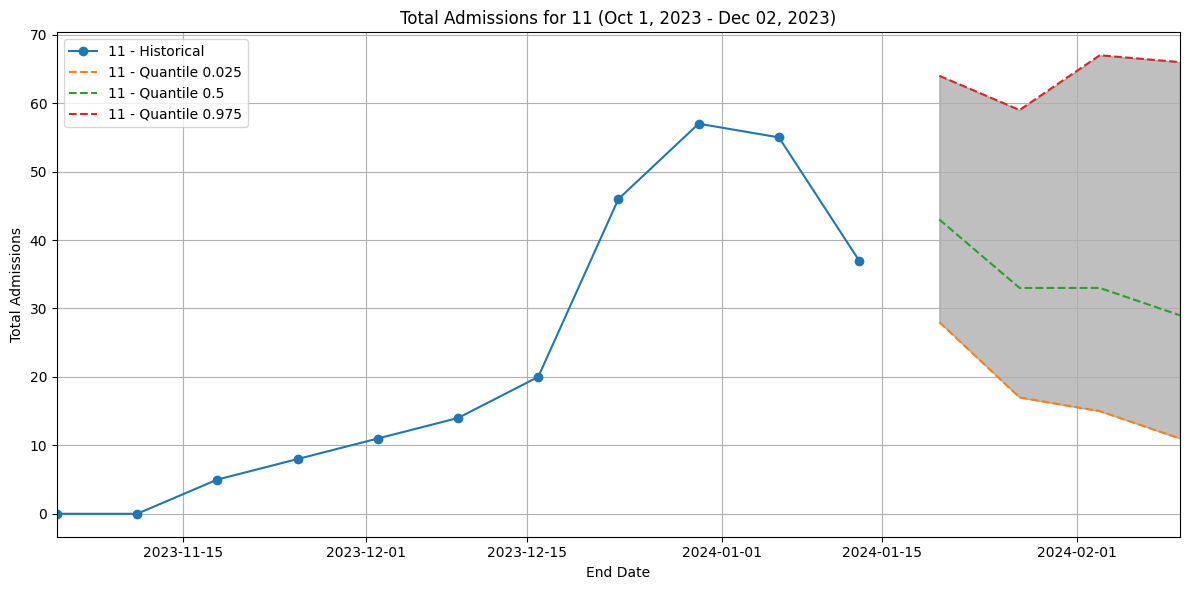

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
hist = dc.copy()
hist = hist.rename(columns={'date': 'Week_end', 'location': 'fips'})


quantile_result2 = quantile_result1[quantile_result1['reference_date'] == '2024-01-20']
quantile_result2
hist['Week_end'] = pd.to_datetime(hist['Week_end'])
hist['fips'] =hist['fips'].astype(str).str.zfill(2)
quantile_result2['target_end_date'] = pd.to_datetime(quantile_result2['target_end_date'])

quantiles = [0.025, 0.5, 0.975]
quantile_data = quantile_result2[quantile_result2['output_type_id'].isin(quantiles)]

filtered_hist = hist[(hist['Week_end'] >= '2023-11-01')]
filtered_quantile_data = quantile_data[(quantile_data['target_end_date'] >= '2023-10-01')]

unique_states = hist['fips'].unique()

for state in unique_states:
    state_hist_data = filtered_hist[filtered_hist['fips'] == state]
    state_quantile_data = filtered_quantile_data[filtered_quantile_data['location'] == state]

    plt.figure(figsize=(12, 6))

    plt.plot(state_hist_data['Week_end'], state_hist_data['value'], marker='o', linestyle='-', label=f'{state} - Historical')

    for q in quantiles:

        q_data = state_quantile_data[state_quantile_data['output_type_id'] == q]
        plt.plot(q_data['target_end_date'], q_data['value'], marker='', linestyle='--', label=f'{state} - Quantile {q}')

        # Fill the area between 0.025 and 0.975 quantiles with color
        if q == 0.025:
            lower_q_data = q_data
        else:
            upper_q_data = q_data

    plt.fill_between(lower_q_data['target_end_date'], lower_q_data['value'], upper_q_data['value'], color='gray', alpha=0.5)

    plt.title(f'Total Admissions for {state} (Oct 1, 2023 - Dec 02, 2023)')
    plt.xlabel('End Date')
    plt.ylabel('Total Admissions')
    plt.xlim(state_hist_data['Week_end'].min(), state_quantile_data['target_end_date'].max())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
